In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from types import SimpleNamespace
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import random
import torch.nn.functional as F
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import wandb
from utilities import *

In [10]:
#loading data
train,valid,test=load_data(data_path,lang)

add_start_end(train) #adding start and end characters
add_start_end(valid)
add_start_end(test)

train_src_chars,train_target_chars=get_unique_chars(train) # obtain unique charcaters
valid_src_chars,valid_target_chars=get_unique_chars(valid)
test_src_chars,test_target_chars=get_unique_chars(test)
train_target_chars.add('*') # extra char to handle unknowns in valid and test data.
    
src_char_idx,src_idx_char=get_char_map(train_src_chars) # create map for each unique charcter to -> integer
target_char_idx,target_idx_char=get_char_map(train_target_chars)

encoder_vocab_size=len(src_char_idx)+1 # one extra for padding
decoder_vocab_size=len(target_char_idx)+1 # one extra for padding

max_seq_length=train[0].apply(lambda x:len(x)).max() # maximum sequence lenght in Latin
max_target_length=train[1].apply(lambda x:len(x)).max() # maximum target length


#creating word vectors
train_src_int,train_target_int=vectorize(train,src_char_idx,target_char_idx,max_seq_length)
valid_src_int,valid_target_int=vectorize(valid,src_char_idx,target_char_idx,max_seq_length)
test_src_int,test_target_int=vectorize(test,src_char_idx,target_char_idx,max_seq_length)


def main():
#     wandb.init()
#     config=wandb.config 
#     run_name=f'Attention -Yes Cell-{config.cell_type} Hidden-{config.hidden_size} Embedding-{config.embedding_size} Bidir-{config.bidirectional} Dropout -{config.dropout} EL-{config.encoder_num_layers} DL-{config.decoder_num_layers}'
#     wandb.run.name=run_name
    config.encoder_vocab_size=encoder_vocab_size
    config.decoder_vocab_size=decoder_vocab_size
    config.max_seq_length=max_seq_length

    model=AttentionSeq2Seq(config).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    for epoch in range(config.epochs):
        train_loss=0
        train_acc=0
        model.train()
        batch_no=0
        for data in get_batch(train_src_int,train_target_int,config.batch_size):
#             print(batch_no)
            batch_no+=1
            x=data[0]
            y=data[1]
            x=x.to(torch.int64).T
            y=y.to(torch.int64).T
            outputs,attention_scores=model.forward(x,y)
            output=outputs.reshape(-1,outputs.shape[2])
            target=y.reshape(-1)
            optimizer.zero_grad()
            target=target-1
            target[target<0]=0
            loss = criterion(output, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)# gradient clipping 
            optimizer.step()# update parameters
            train_loss+=loss.item()*config.batch_size

            batch_acc=cal_acc(outputs,y)
            train_acc+=batch_acc
        train_loss/=len(train_src_int)
        train_acc/=batch_no 
        model.eval()

        valid_loss=0
        valid_acc=0
        batch_no=0
        with torch.no_grad():# disable storing computation graph
            for data in get_batch(valid_src_int,valid_target_int,config.batch_size):
                batch_no+=1
                x=data[0]
                y=data[1]
                x=x.to(torch.int64).T
                y=y.to(torch.int64).T
                outputs,attention_scores=model.forward(x,y,prediction=True)# prediction set to True to disable teacher forcing
                output=outputs.reshape(-1,outputs.shape[2])
                target=y.reshape(-1)
                target=target-1
                target[target<0]=0
                loss = criterion(output, target)
                valid_loss+=loss.item()*config.batch_size
                valid_acc+=cal_acc(outputs,y)
            valid_loss/=len(valid_src_int)
            valid_acc/=batch_no
        print(f'Epoch: {epoch+1} Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f} Train Acc: {train_acc:.4f}  Valid Acc: {valid_acc:.4f}')
#         wandb.log({'train accuracy':train_acc*100,'train loss':train_loss,'valid accuracy':valid_acc*100,'valid loss':valid_loss})
#     wandb.finish()
    return model

In [11]:
config={'batch_size': 256, 'bidirectional': 'Yes', 'cell_type': 'GRU', 'decoder_num_layers': 2, 'dropout': 0.2, 'embedding_size': 256, 'encoder_num_layers': 3, 'epochs': 15, 'hidden_size': 512}

config=SimpleNamespace(**config)

model=main()

Epoch: 1 Train Loss: 1.9087 Valid Loss: 1.2351 Train Acc: 0.0527  Valid Acc: 0.2686
Epoch: 2 Train Loss: 0.6969 Valid Loss: 0.9873 Train Acc: 0.3984  Valid Acc: 0.4280
Epoch: 3 Train Loss: 0.5803 Valid Loss: 0.9711 Train Acc: 0.5130  Valid Acc: 0.4858
Epoch: 4 Train Loss: 0.5406 Valid Loss: 0.9654 Train Acc: 0.5672  Valid Acc: 0.4958
Epoch: 5 Train Loss: 0.5024 Valid Loss: 0.9512 Train Acc: 0.6142  Valid Acc: 0.5068
Epoch: 6 Train Loss: 0.4802 Valid Loss: 0.9365 Train Acc: 0.6456  Valid Acc: 0.5205
Epoch: 7 Train Loss: 0.4621 Valid Loss: 0.9506 Train Acc: 0.6686  Valid Acc: 0.5269
Epoch: 8 Train Loss: 0.4506 Valid Loss: 0.9819 Train Acc: 0.6918  Valid Acc: 0.5400
Epoch: 9 Train Loss: 0.4351 Valid Loss: 0.9572 Train Acc: 0.7158  Valid Acc: 0.5376
Epoch: 10 Train Loss: 0.4290 Valid Loss: 0.9701 Train Acc: 0.7324  Valid Acc: 0.5337
Epoch: 11 Train Loss: 0.4271 Valid Loss: 0.9876 Train Acc: 0.7398  Valid Acc: 0.5444
Epoch: 12 Train Loss: 0.4210 Valid Loss: 0.9791 Train Acc: 0.7507  Valid A

In [12]:
wandb.login(key='24434976526d9265fdbe2b2150787f46522f5da4')
wandb.init(project='Attention_Best_model')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


test accuracy,▁
test accuracy,0.50708


In [13]:
# test data predictions into a csv file

target_end_index=target_char_idx['$']
li=[]
batch_no=0
test_acc=0
for data in get_batch(test_src_int,test_target_int,config.batch_size):
    batch_no+=1
    x=data[0]
    y=data[1]
    x=x.to(torch.int64).T
    y=y.to(torch.int64).T
    target=y.detach().cpu().numpy()
    src=x.detach().cpu().numpy()
    outputs,_=model.forward(x,y,prediction=True)
    batch_acc=cal_acc(outputs,y)
    test_acc+=batch_acc
    out=outputs.argmax(axis=2).detach().cpu().numpy()+1
    for idx in range(out.shape[1]):
        each_out=out[:,idx]
        each_target=target[:,idx]
        each_src=src[:,idx]
        src_last_index=np.max(np.nonzero(each_src))
        src_str=decode_src(each_src[:src_last_index],src_idx_char)
#         print(src_str,end=" ")
        target_last_index=np.max(np.nonzero(each_target))
        target_str=decode_target(each_target[:target_last_index],target_idx_char,target_end_index)
#         print(target_str,end=" ")
        
        for i,value in enumerate(each_out):
            if value==target_end_index:
                pred_end_index=i
                break
        pred_str=decode_target(each_out[:pred_end_index],target_idx_char,target_end_index)
#         print(pred_str)
        li.append([src_str,target_str,pred_str])

test_acc/=batch_no
wandb.log({'test accuracy':test_acc})
print(f"test accuracy is:  {test_acc:.4f}")
df=pd.DataFrame(li,columns=['Source','Target','Predicted'])
df.to_csv('Test_predictions_Attention.csv',index=False)

test accuracy is:  0.5098


In [14]:
! wget https://fonts.google.com/download?family=Mandali -O mandali.zip
! unzip mandali.zip -d mandali 

--2023-05-20 19:54:22--  https://fonts.google.com/download?family=Mandali
Resolving fonts.google.com (fonts.google.com)... 74.125.20.100, 74.125.20.101, 74.125.20.138, ...
Connecting to fonts.google.com (fonts.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘mandali.zip’

mandali.zip             [ <=>                ] 222.23K  --.-KB/s    in 0.1s    

2023-05-20 19:54:23 (1.99 MB/s) - ‘mandali.zip’ saved [227564]

Archive:  mandali.zip
  inflating: mandali/OFL.txt         
  inflating: mandali/Mandali-Regular.ttf  


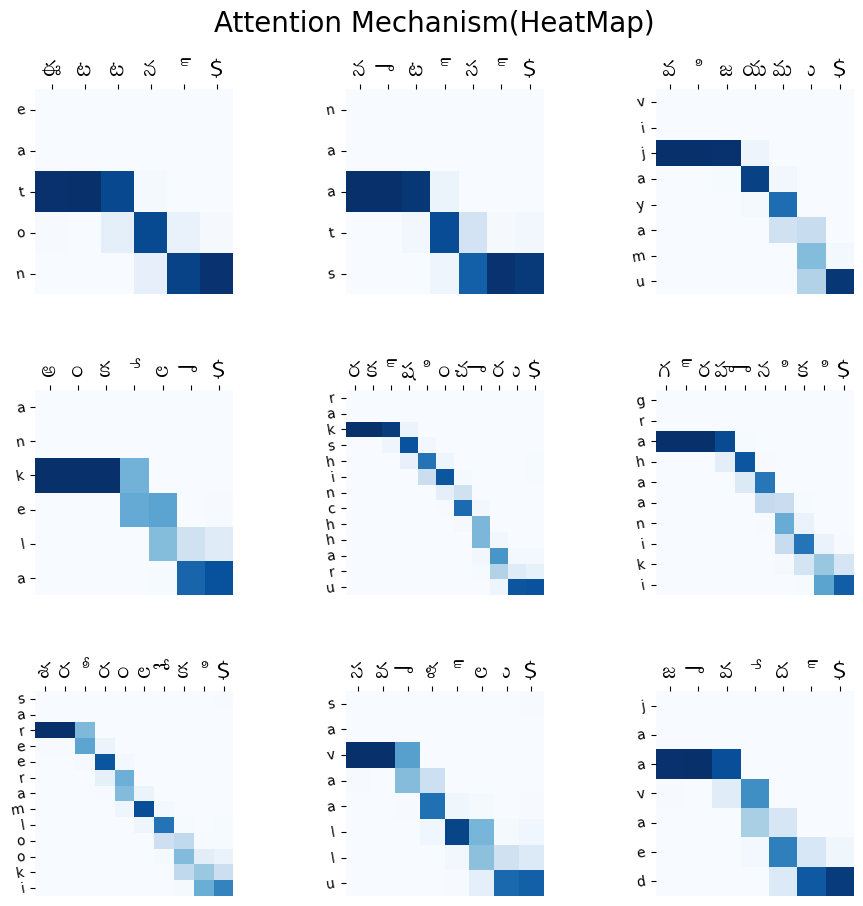

In [20]:
# Attention map visulaization
tel_font = FontProperties(fname = 'mandali/Mandali-Regular.ttf') 

model.eval()
for data in get_batch(test_src_int,test_target_int,config.batch_size):
    x=data[0]
    y=data[1]
    x=x.to(torch.int64).T
    y=y.to(torch.int64).T
    outputs,attention_scores=model.forward(x,y,prediction=True)
#     print(outputs.shape)
    attention_scores=attention_scores.permute(1,0,2)
    break

scores=attention_scores.detach().cpu().numpy()
target=y.detach().cpu().numpy()
src=x.detach().cpu().numpy()
out=outputs.argmax(axis=2).detach().cpu().numpy()+1


rand_idx=random.sample(range(0,config.batch_size),9)
fig, axes = plt.subplots(3, 3, figsize=(10,10))
fig.tight_layout(pad=5.0)
fig.subplots_adjust(top=0.90)

axes = axes.ravel()
for idx in range(9):
#     print("*"*20)
    each_target=target[:,rand_idx[idx]] #(TL,N)
    each_out=out[:,rand_idx[idx]]  #(TL,N)
    each_score=scores[rand_idx[idx]] # (B,TL,SL)
    each_src=src[:,rand_idx[idx]] # (SL,N)
    pred_end_index=0
    for i,value in enumerate(each_out):
        if value==target_end_index:
            pred_end_index=i
            break
    target_last_index=np.max(np.nonzero(each_target))
    pred_str=decode_target(each_out[:pred_end_index],target_idx_char,target_end_index)
    src_last_index=np.max(np.nonzero(each_src))
    eng_str=decode_src(each_src[:src_last_index],src_idx_char)
    mat=each_score[1:pred_end_index+1,1:src_last_index+1]
    mat=mat.T/mat.T.sum(axis=0)
    sns.heatmap(mat, ax=axes[idx],cmap='Blues',cbar=False)
    axes[idx].set_yticklabels(list(eng_str),rotation=10)  
    axes[idx].set_xticklabels(pred_str+"$",fontproperties = tel_font,fontdict={'fontsize':16})
    axes[idx].xaxis.tick_top()
    
fig.suptitle('Attention Mechanism(HeatMap)',fontsize=20)
wandb.log({'Attention ':wandb.Image(plt)})
plt.show()